---

# Acessando um Computador Quântico Real (IBM Quantum)

Neste novo notebook vamos:

1. Conectar-nos à nuvem da **IBM Quantum**.
2. Selecionar um backend (processador quântico real).
3. Reproduzir passo a passo a preparação do estado de Bell  
   \(\displaystyle \ket{\Phi^+} = \tfrac{1}{\sqrt 2}\bigl(\ket{00}+\ket{11}\bigr)\).
4. Executar o circuito em hardware real e comparar os histogramas obtidos em cada etapa.

---

## 1. Configurando o acesso

Para utilizar um backend real, você precisa de uma **conta gratuita** no IBM Quantum e do **token de API** associado.

```python
# Instalação (se ainda não tiver)
# %pip install qiskit qiskit-ibm-runtime --upgrade

In [ ]:
import qiskit                          # ferramentas para construir circuitos
from qiskit_ibm_runtime import QiskitRuntimeService  # acesso à nuvem IBM

service = QiskitRuntimeService(channel="ibm_quantum", token='818a3193f676266ae1387c88051fe918473506cc4fa8d65ec58504f98222ff930dd2ff386135bed2bbb0930a320fbbd4730aee3c5052d99c5ac7b984cd3d9383')



---

## Salvando sua conta (faça **uma única vez**)

Depois de criar sua conta em **IBM Quantum** e copiar o seu *API token* (uma sequência de 32 caracteres), salve-o localmente com:

```python
from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    token="SEU_TOKEN_AQUI",   # ← cole seu token aqui
    overwrite=True            # sobrescreve se já existir um token salvo
)


In [3]:
QiskitRuntimeService.save_account(channel="ibm_quantum"
                                  ,token='818a3193f676266ae1387c88051fe918473506cc4fa8d65ec58504f98222ff930dd2ff386135bed2bbb0930a320fbbd4730aee3c5052d99c5ac7b984cd3d9383')

AccountAlreadyExistsError: 'Named account (default-ibm-quantum) already exists. Set overwrite=True to overwrite.'

---

## Escolhendo o backend e verificando portas nativas

Depois que o serviço (`service`) estiver ativo, selecionamos um **backend** específico — isto é, um processador quântico real — pelo nome:

```python
backend = service.backend(name="ibm_sherbrooke")


In [4]:
backend = service.backend(name = "ibm_sherbrooke")
backend.operation_names

['if_else',
 'delay',
 'sx',
 'ecr',
 'x',
 'switch_case',
 'measure',
 'id',
 'reset',
 'for_loop',
 'rz']

---

# Construindo um Estado de Bell Passo a Passo (visão resumida)

Queremos criar o estado de Bell  

$$
\ket{\Phi^+}=\tfrac{1}{\sqrt2}\bigl(\ket{00}+\ket{11}\bigr)
$$  

começando de $\ket{00}$ no hardware da **IBM Quantum**.  
A sequência de portas é:

1. **Nada** (estado inicial)  
2. **Hadamard** no qubit 0  
3. **CNOT** (controle = qubit 0, alvo = qubit 1)

Em cada etapa listamos o estado esperado e as probabilidades de medição.

---

## Etapa 0 — Estado inicial

- Estado: $\ket{\psi_0}=\ket{00}$  
- Probabilidades previstas  
  - `00`: 100 %  
  - `01`,`10`,`11`: 0 %

---

## Etapa 1 — Após Hadamard no qubit 0

- Estado:  
  $$\ket{\psi_1}=H\ket{0}\otimes\ket{0}
  =\tfrac{1}{\sqrt2}\bigl(\ket{00}+\ket{10}\bigr)$$
- Probabilidades previstas  
  - `00`: 50 %  
  - `10`: 50 %  
  - `01`,`11`: 0 %

---

## Etapa 2 — Após CNOT

- Estado:  
  $$\ket{\psi_2}=\tfrac{1}{\sqrt2}\bigl(\ket{00}+\ket{11}\bigr)=\ket{\Phi^+}$$
- Probabilidades previstas  
  - `00`: 50 %  
  - `11`: 50 %  
  - `01`,`10`: 0 %

---

## Observação sobre execuções no hardware real

Em um processador quântico real os resultados **não serão perfeitos** devido a:

- **Ruído de porta** (fidelidade finita das operações unitárias);  
- **Decoerência** (relaxação $T_1$ e desfasagem $T_2$);  
- **Erros de leitura** (imperfeições na medição).

Consequentemente, você deve observar contagens pequenas em resultados “impossíveis” e leves desvios das porcentagens ideais.  
Usaremos esses dados para discutir fidelidade experimental e técnicas de mitigação.

---
---

## Simulador com ruído: uma ferramenta essencial antes da execução real

Antes de enviar um circuito quântico para execução em um **computador quântico real**, é altamente recomendado testá-lo em um **simulador com ruído realista**.

O Qiskit oferece o recurso de extrair o **modelo de ruído** de qualquer backend físico, simulando o comportamento esperado levando em conta:

- Fatores como fidelidade das portas,
- Tempos de coerência ($T_1$ e $T_2$),
- Erros de leitura,
- Mapa de conectividade entre os qubits.

---

### Vantagens de usar um simulador com ruído

- ✅ **Antecipar imperfeições** antes de submeter ao hardware real.  
- ✅ **Comparar o circuito ideal com o circuito transpilado** (incluindo SWAPs e rearranjos).  
- ✅ **Economizar tempo de fila**: você pode depurar o circuito localmente sem esperar por execução real.  
- ✅ **Ajustar estratégias de mitigação** com base em simulações realistas.  
- ✅ **Explorar limites de fidelidade** para circuitos maiores sem custo computacional real.

---

### Como fazemos isso no Qiskit?

Após escolher um backend real, você pode extrair seu modelo de ruído com:

```python
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit.primitives import BackendSamplerV2

noise_model = NoiseModel.from_backend(backend)        # extrai ruído real
backend_sim = AerSimulator(noise_model=noise_model)   # backend simulado
sampler_sim = BackendSamplerV2(backend=backend_sim)   # sampler para simulação

job = sampler_sim.run([circuit_transpilado])


Backend escolhido: ibm_brisbane


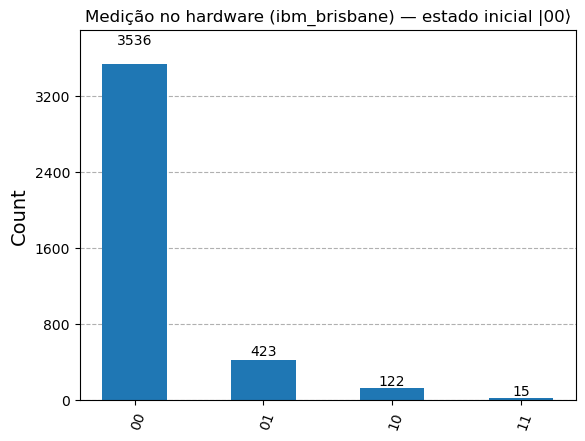

In [ ]:
# ------------------------------------------------------------------
# PASSO 0 — Medição do estado |00⟩ no hardware real da IBM Quantum
# ------------------------------------------------------------------
# Bibliotecas e serviço
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from IPython.display import display

# 1) Conecta-se à sua conta (token já salvo previamente)
service = QiskitRuntimeService()



# 2) Escolhe o backend real menos ocupado com ≥127 qubits
backend = service.least_busy(operational=True,
                             simulator=False,
                             min_num_qubits=127)
print("Backend escolhido:", backend.name)

# 3) Constrói o circuito |00⟩ (nenhuma porta), apenas medições
q = QuantumRegister(2, "q")
c = ClassicalRegister(2, "c")
qc = QuantumCircuit(q, c)
qc.measure(q, c)          # mede q0→c0, q1→c1

# 4) Transpila para a topologia do backend
target = backend.target
pm = generate_preset_pass_manager(target=target,
                                  optimization_level=1)
qc_isa = pm.run(qc)        # circuito pronto para hardware

# 5) Executa no hardware com o SamplerV2
sampler = Sampler(mode=backend)
job = sampler.run([qc_isa])        # unica shot list
result = job.result()
counts_real = result[0].data.c.get_counts()

# 6) Exibe o histograma medido
display(plot_histogram(counts_real,
                       title=f"Medição no hardware ({backend.name}) — estado inicial |00⟩"))


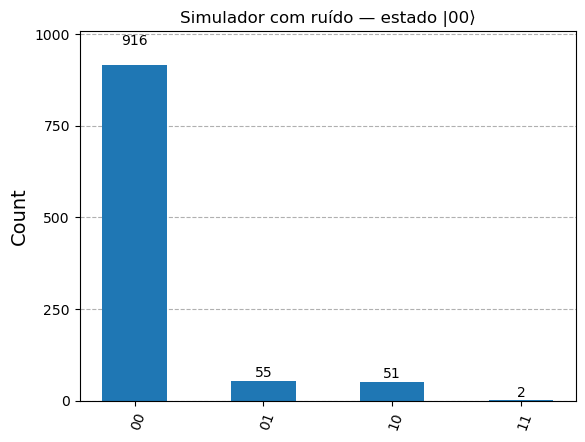

In [6]:
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit.primitives import BackendSamplerV2

# Cria modelo de ruído a partir do backend real
noise_model = NoiseModel.from_backend(backend)

# Backend simulador com esse ruído
backend_sim = AerSimulator(noise_model=noise_model)
sampler_sim = BackendSamplerV2(backend=backend_sim)

# Executa o mesmo circuito transpilado
job_sim = sampler_sim.run([qc_isa])
counts_sim = job_sim.result()[0].data.c.get_counts()

display(plot_histogram(counts_sim,
                       title="Simulador com ruído — estado |00⟩"))


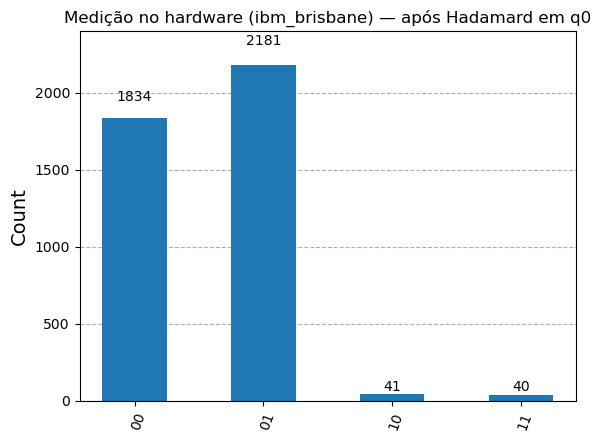

In [7]:
# ------------------------------------------------------------------
# PASSO 1 — Medição após aplicação de Hadamard no qubit 0
# ------------------------------------------------------------------

# 1) Constrói o circuito com Hadamard no qubit 0 e medições
q = QuantumRegister(2, "q")
c = ClassicalRegister(2, "c")
qc_h = QuantumCircuit(q, c)

qc_h.h(q[0])         # aplica Hadamard no qubit 0
qc_h.measure(q, c)   # mede q0→c0, q1→c1

# 2) Transpila o circuito para o backend escolhido anteriormente
qc_isa_h = pm.run(qc_h)

# 3) Executa no hardware com SamplerV2
job_h = sampler.run([qc_isa_h])
result_h = job_h.result()
counts_hardware = result_h[0].data.c.get_counts()

# 4) Plota histograma da execução real
display(plot_histogram(counts_hardware,
                       title=f"Medição no hardware ({backend.name}) — após Hadamard em q0"))


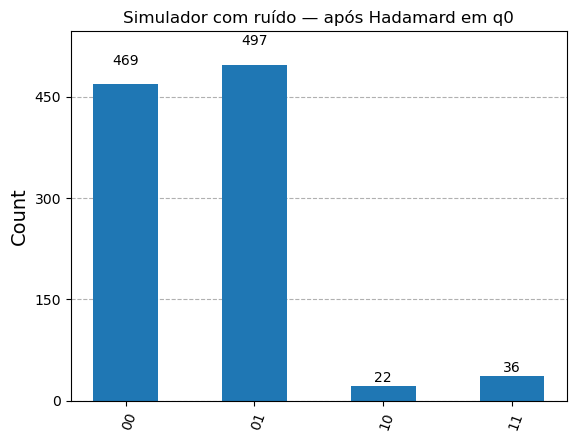

In [8]:
# Executa no simulador com ruído do backend real
job_sim_h = sampler_sim.run([qc_isa_h])
counts_sim_h = job_sim_h.result()[0].data.c.get_counts()

display(plot_histogram(counts_sim_h,
                       title="Simulador com ruído — após Hadamard em q0"))


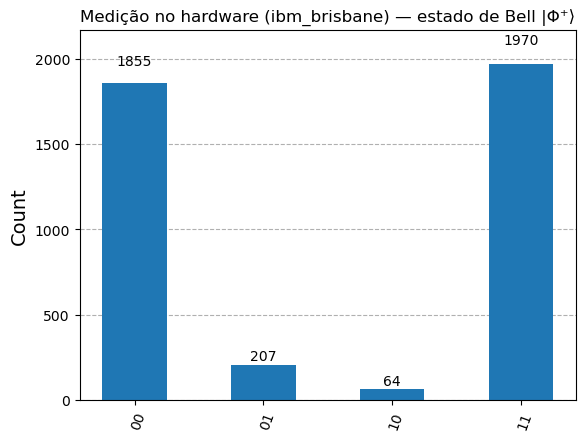

In [9]:
# ------------------------------------------------------------------
# PASSO 2 — Medição após Hadamard + CNOT (estado de Bell |Φ⁺⟩)
# ------------------------------------------------------------------

# 1) Constrói o circuito com H no qubit 0 e CNOT entre q0 → q1
q = QuantumRegister(2, "q")
c = ClassicalRegister(2, "c")
qc_bell = QuantumCircuit(q, c)

qc_bell.h(q[0])            # Hadamard no qubit 0
qc_bell.cx(q[0], q[1])     # CNOT: controle q0, alvo q1
qc_bell.measure(q, c)      # Mede ambos

# 2) Transpila o circuito para o backend
qc_isa_bell = pm.run(qc_bell)

# 3) Executa no hardware real
job_bell = sampler.run([qc_isa_bell])
result_bell = job_bell.result()
counts_bell = result_bell[0].data.c.get_counts()

# 4) Exibe histograma da execução real
display(plot_histogram(counts_bell,
                       title=f"Medição no hardware ({backend.name}) — estado de Bell |Φ⁺⟩"))


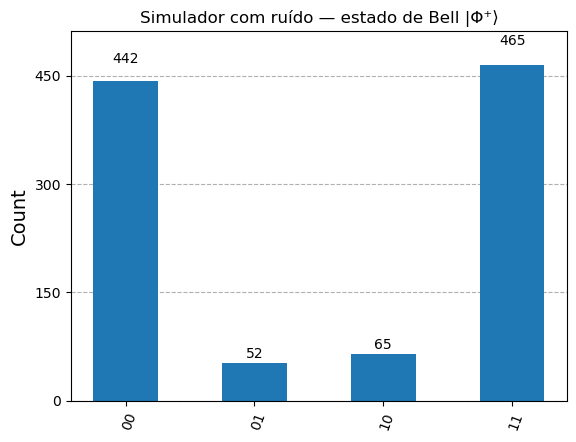

In [10]:
# Executa em simulador com ruído do backend real
job_sim_bell = sampler_sim.run([qc_isa_bell])
counts_sim_bell = job_sim_bell.result()[0].data.c.get_counts()

display(plot_histogram(counts_sim_bell,
                       title="Simulador com ruído — estado de Bell |Φ⁺⟩"))
